In [1]:
!pip3 install numpy pandas matplotlib sklearn 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [13]:
d_df  = pd.read_csv('../bitfear/direction.csv')
d_df['timestamp'] = pd.to_datetime(d_df['timestamp'], format='%Y-%m-%d %H:%M:%S').astype(int)
d_df['vxbt_direction_next'] = d_df['vxbt_direction'].shift(1)
d_df = d_df.dropna().iloc[::-1].reset_index(drop = True)
d_df



,timestamp,vxbt_direction,tweet_vol_direction,sentiment_direction,gtrend_direction,index_direction,vxbt_direction_next
0,1556668800000000000,0,0,0,0,0,1.0
1,1556669100000000000,1,-1,-1,-1,-1,1.0
2,1556669400000000000,1,-1,1,-1,1,-1.0
3,1556669700000000000,-1,-1,1,-1,1,1.0
4,1556670000000000000,1,-1,0,-1,1,1.0
...,...,...,...,...,...,...,...
86366,1582587300000000000,-1,0,1,1,0,1.0
86367,1582587600000000000,1,-1,1,1,-1,-1.0
86368,1582587900000000000,-1,-1,1,1,1,-1.0
86369,1582588200000000000,-1,-1,1,1,1,1.0


In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

max_uplift_window = 48
cross_validation_size = 10
size = d_df.shape[0]
dataset_size_divisible_by_ten = ((size - max_uplift_window)//cross_validation_size)*cross_validation_size
offset = size - dataset_size_divisible_by_ten 
uplift_window = []
uplift_score = []

def get_window(df, start, size, offset = offset):
    return df[['vxbt_direction','tweet_vol_direction','sentiment_direction','gtrend_direction','index_direction']].iloc[offset + start - size: offset + start].to_numpy().ravel()
    

y_data = []
for j in range(dataset_size_divisible_by_ten):
        y_data.append(int(d_df['vxbt_direction_next'][j + offset]))

for i in range(1,max_uplift_window + 1):
    x_data = []
    for j in range(dataset_size_divisible_by_ten):
        x_data.append(get_window(d_df,j,i))
    # Using the parameters that were determined the best in time_series_anaylsis.ipynb
    model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, max_depth=4, min_samples_split=2,
                                    min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
    score = cross_val_score(model, x_data, y_data, cv=cross_validation_size)
    print(score)
    uplift_window.append(i)
    uplift_score.append(score)
    del x_data
    print(i)

[0.40373031 0.39909639 0.41183967 0.40882762 0.41380908 0.40071826
 0.40373031 0.37778035 0.41890639 0.38519462]
1
[0.41821131 0.40048656 0.43836886 0.41612604 0.43385079 0.41473587
 0.42099166 0.3952734  0.43141798 0.3955051 ]
2
[0.42319277 0.40291937 0.44520389 0.41716867 0.44056997 0.42168675
 0.4242354  0.39654773 0.43755792 0.40199259]
3
[0.42829008 0.40245598 0.45609361 0.42006487 0.44531974 0.42944856
 0.4273633  0.39990732 0.44358202 0.40176089]
4
[0.42921687 0.40477294 0.45667285 0.42307692 0.44381372 0.4302595
 0.43211307 0.40187674 0.44230769 0.40488879]
5
[0.4273633  0.40627896 0.46061168 0.42330862 0.44555144 0.43176552
 0.43327155 0.40639481 0.4476367  0.40442539]
6
[0.42991196 0.41114458 0.46026413 0.42075996 0.447405   0.43419833
 0.43547266 0.403962   0.44705746 0.40917516]
7
[0.43072289 0.40627896 0.46443466 0.4242354  0.44578313 0.4387164
 0.43593605 0.40732159 0.45157553 0.41033364]
8
[0.43222892 0.40824838 0.46860519 0.42666821 0.44636237 0.44033828
 0.43964319 0.4

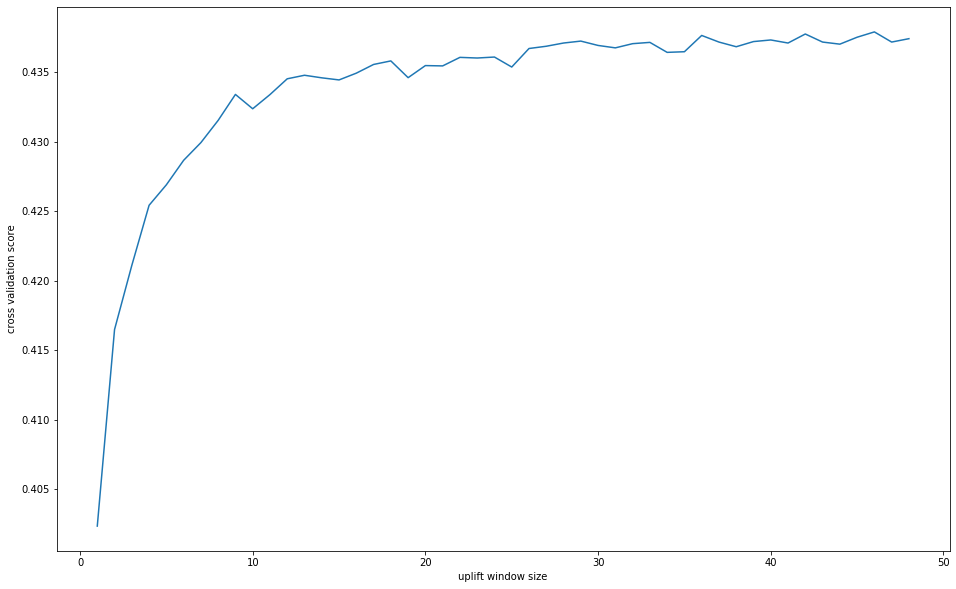

In [34]:
plt.rcParams["figure.figsize"] = (16, 10)
   
uplift_score = [i.mean() for i in uplift_score] 
    
plt.plot(uplift_window, uplift_score) 
plt.xlabel('uplift window size') 
plt.ylabel('cross validation score') 

plt.show() 